## Radargestützte Niederschlagsschätzung: Fallstudie Berlin, 12.7.2018

### Umgebung einrichten

In [1]:
import wradlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import helpers as h
import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, to_hex

In [2]:
%matplotlib inline

### Konfiguration

In [3]:
#dxdir = "/media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190610/raa00-dx_10392-1906100000-pro---bin"
dxdirpattern = "/media/x/data/radar/dx/pro/DX-pro_%s/DX-pro_%s/raa00-dx_10392-%s-pro---bin"
rwdirpattern = "rw/raa01-rw_10000-%s-dwd---bin.gz"

### Radardaten georeferenzieren

#### aux data

In [4]:
dataset, inLayer = wradlib.io.open_vector("shapes/RBS_OD_ORT_1412.shp")
borders, keys = wradlib.georef.get_vector_coordinates(inLayer)
bbox = inLayer.GetExtent()

#### DX data

In [5]:
# http://www.stadtentwicklung.berlin.de/service/gesetzestexte/de/download/geoinformation/koordinatenreferenzsysteme.pdf
proj = wradlib.georef.epsg_to_osr(25833)

In [6]:
site = (h.radars["pro"]["lon"], h.radars["pro"]["lat"], h.radars["pro"]["alt"])
r = h.specs_dx["r"]
az = h.specs_dx["az"]

In [7]:
coord_dx = wradlib.georef.sweep_centroids(len(az), 1000., len(r), 0.5)
xyz_dx = wradlib.georef.spherical_to_proj(coord_dx[..., 0],
                                          np.degrees(coord_dx[..., 1]),
                                          coord_dx[..., 2], sitecoords=site, proj=proj)

#### RW data

In [8]:
# Get coordinates
rwcoords = wradlib.georef.get_radolan_grid(900,900)
x_rw, y_rw = wradlib.georef.reproject(rwcoords[:,:,0],
                                      rwcoords[:,:,1],
                                      projection_source=wradlib.georef.create_osr("dwd-radolan"),
                                      projection_target=proj)

In [9]:
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[0])**2 + (y_rw - bbox[2])**2)), x_rw.shape))
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[1])**2 + (y_rw - bbox[3])**2)), x_rw.shape))

(610, 742)
(653, 786)


### Niederschlagsschreiber laden

In [10]:
eventdays = "2019-06-06", "2019-06-11", "2019-06-12", "2019-07-20", "2019-07-21", "2019-07-29", "2019-07-31", "2019-08-02"
eventnames= "2019-06-06", "2019-06-11",               "2019-07-20",               "2019-07-29", "2019-07-31", "2019-08-02"

In [11]:
def read_eventday(eventday):
    # First run to extract column info
    sheet_name = dt.datetime.strptime(eventday, "%Y-%m-%d").strftime("%d.%m.%Y")
    # Second extract data
    columns = pd.read_excel("2019/Starkregen Sommer 2019.xlsx", sheet_name=sheet_name).columns
    df = pd.read_excel("2019/Starkregen Sommer 2019.xlsx", sheet_name=sheet_name, skiprows=2, na_values="[-11059] No Good Data For Calculation")
    df.columns = columns
    df = df.drop(columns=['Unnamed: 0'])
    df = df.rename(columns={'Unnamed: 1': "dtime"})
    df.columns = [column[:5] for column in df.columns]
    df['dtime'] = pd.to_datetime(df['dtime'])
    # To UTC
    df.dtime = df.dtime - dt.timedelta(seconds=3600*2)
    df = df.set_index('dtime')
    df = df[~pd.isnull(df.index)]
    return(df)    

In [12]:
gdata = None
for eventday in eventdays:
    print(eventday)
    if gdata is None:
        gdata = read_eventday(eventday)
    else:
        gdata = pd.concat([gdata, read_eventday(eventday)])

2019-06-06
2019-06-11
2019-06-12
2019-07-20
2019-07-21
2019-07-29
2019-07-31
2019-08-02


In [13]:
gauges = pd.read_excel("2019/Starkregen Sommer 2019.xlsx", sheet_name="Standorte", header=None)
gauges = gauges.drop(columns=[0])
gauges.loc[0] = [name.replace(" - Regenmesser", "") for name in gauges.loc[0]]
gauges = pd.DataFrame({"name": gauges.loc[0].tolist(), "x": gauges.loc[2].tolist(), "y": gauges.loc[3].tolist()})
gauges.x = gauges.x.astype("f4")
gauges.y = gauges.y.astype("f4")
gauges["id"] = [name[:5] for name in gauges.name]
gauges = gauges.set_index('id')

In [14]:
# Vegetation according to Regen2018_07_11_bis_07_12_anSenat.xlsx
vegetation = ["01.02", "03.08", "05.03", "05.15", "05.19", "08.01", "11.01", "11.02", "11.03", "12.01", "13.02", "13.04", "14.01", "14.03", "15.01", "15.05", "16.06"]
gauges["vegetation"] = False
gauges.loc[vegetation,"vegetation"] = True

In [15]:
# Flagging spurious gauges
col = eventnames[0]
gauges[col] = False
gauges.loc[["02.05", "06.01"], col] = True
col = eventnames[1]
gauges[col] = False
gauges.loc[["03.09", "05.19", "06.01", "06.05", "11.06", "13.01", "14.01", "14.06"], col] = True
col = eventnames[2]
gauges[col] = False
gauges.loc[["06.01"], col] = True
col = eventnames[3]
gauges[col] = False
gauges.loc[[], col] = True
col = eventnames[4]
gauges[col] = False
gauges.loc[["03.08", "06.12", "15.01"], col] = True
col = eventnames[5]
gauges[col] = False
gauges.loc[["03.08", "06.12", "12.11", "14.01"], col] = True

### Räumliches Setup

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


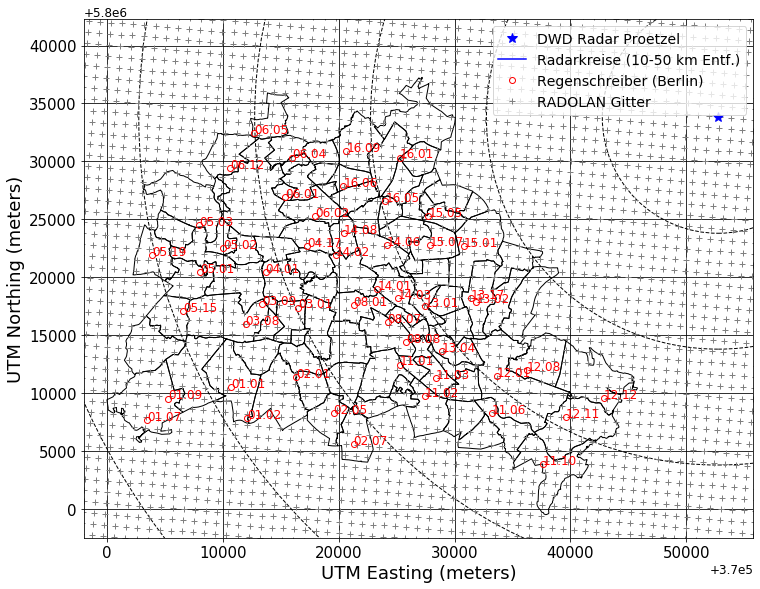

In [16]:
plt.rc('font', **{'size'   : 12})

fig = plt.figure(figsize=(12,12))

xoffset = 370000
yoffset = 5800000

ax = fig.add_subplot(111, aspect="equal")
#pm = plt.pcolormesh(x_rw, y_rw, np.ones((900,900)), 
#                    facecolor="None", edgecolor="grey", cmap=plt.cm.gist_gray, vmax=1, linewidth=0.1)
plt.plot(x_rw, y_rw, "k+", color="gray")
site_xy = wradlib.georef.reproject(site, projection_target=proj)
plt.plot(site_xy[0], site_xy[1], "b*", ms=10, label="DWD Radar Proetzel")
for rad in np.arange(1,7)*10000:
    circle = plt.Circle(site_xy[0:2], radius=rad, facecolor="None", edgecolor="black", ls="dashed")
    ax.add_artist(circle)
#wradlib.vis.plot_ppi_crosshair(site=site, ranges=[60000,], angles=[90,], proj=proj)
#wradlib.vis.plot_ppi_crosshair(site=site, ranges=np.arange(1,6)*10000,
#                               angles=[90], proj=proj,
#                               line=dict(color='none'),
#                               circle={'edgecolor': 'blue', "linewidth": 1., "linestyle":"-"})
ax.plot([], [], "b-", label="Radarkreise (10-50 km Entf.)")
#cb = plt.colorbar(pm, shrink=0.5)
wradlib.vis.add_lines(ax, borders, color='black', lw=1)
plt.plot(gauges.x, gauges.y, "go", markerfacecolor="None", mec="red", label="Regenschreiber (Berlin)")
for i in range(len(gauges)):
    plt.text(gauges.x[i], gauges.y[i], gauges.name[i][:5], horizontalalignment="left", color="red")
               
    

#for i in range(len(gauges)):
#    color = "red"
#    if gauges.veg[i]=="geprüft":
#        color="white"
#    plt.text(gauges.x[i], gauges.y[i], "%d" % gageprec[i],
#             horizontalalignment='center', verticalalignment='center', color=color, fontsize=12)
plt.grid(color="black")
plt.xlabel("UTM Easting (meters)", fontsize=18)
plt.ylabel("UTM Northing (meters)", fontsize=18)
bufr = 10000
plt.xlim(bbox[0]-2000, bbox[1]+10000)
plt.ylim(bbox[2]-2000, bbox[3]+5000)
ax.tick_params(labelsize=15)
ax.plot([], [], "k+", color="gray", label="RADOLAN Gitter")

plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.legend(fontsize=14)
#plt.title("DX")


In [17]:
starts = ["2019-06-06 12:00:00", "2019-06-11 19:00:00", "2019-07-20 19:00:00", "2019-07-29 14:00:00", "2019-07-31 16:00:00", "2019-08-02 13:00:00"]
ends   = ["2019-06-06 21:00:00", "2019-06-12 03:00:00", "2019-07-21 00:00:00", "2019-07-29 18:00:00", "2019-07-31 20:00:00", "2019-08-02 17:00:00"]

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


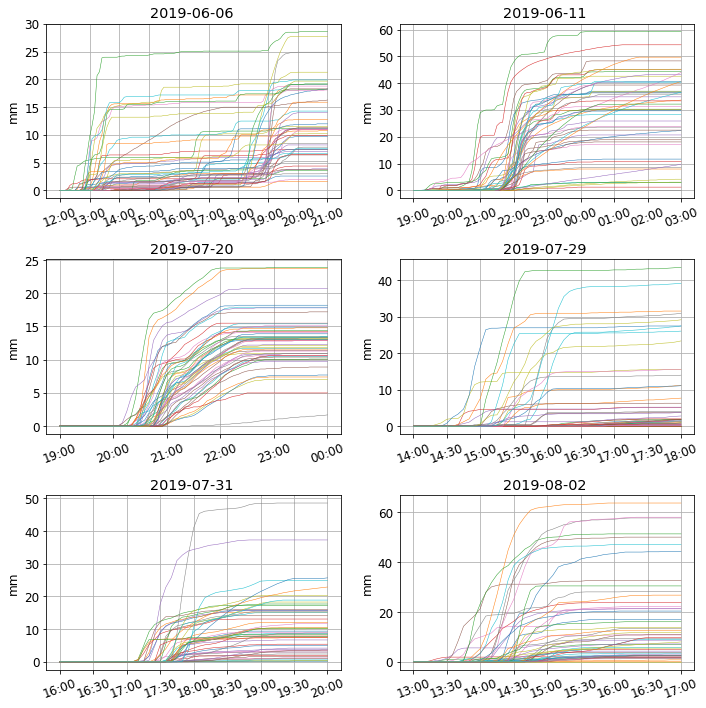

In [18]:
plt.rc('font', **{'size'   : 12})

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
ax = ax.ravel()

for i in range(len(starts)):
    plt.sca(ax[i])
    tmp = gdata[starts[i]:ends[i]]
    for column in tmp.columns:
        plt.plot(tmp.index, tmp[column].cumsum(), lw=0.5)
    plt.title("%s" % starts[i][0:11])
    plt.ylabel("mm")
    plt.grid()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=20)
#fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("events_gauges.pdf", dpi=200, bbox_inches="tight")

### Radardaten laden und prozessieren

In [19]:
def proc_dx(dtimes, dxdirpattern):
    dbz = np.zeros((len(dtimes), len(az), len(r))) * np.nan
    for i, dtime in enumerate(dtimes):
        #dxpath = "/media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190610/raa00-dx_10392-1906100000-pro---bin"
        #          /media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190606/raa00-dx_10392-1906061200-pro---bin
        fpath = dxdirpattern % (dtime.strftime("%Y%m"), dtime.strftime("%Y%m%d"), dtime.strftime("%y%m%d%H%M") )
        try:
            data, meta = wradlib.io.read_dx(fpath)
            dbz[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
            dbz[i] = 0
    # to precipitation depth
    dxprec = h.dbz2depth(dbz)
    pia = wradlib.atten.correct_attenuation_constrained(dbz, a_max=1.67e-4, a_min=2.33e-5, n_a=100,
                                                        b_max=0.7, b_min=0.65, n_b=6, gate_length=1.,
                                                        constraints=[wradlib.atten.constraint_dbz,
                                                                     wradlib.atten.constraint_pia],
                                                        constraint_args=[[59.0], [10.0]])
    dxprec2 = h.dbz2depth(dbz + pia)
    print("")
    return(dxprec, dxprec2)

In [20]:
def proc_rw(dtimes, rwdirpattern):
    tstart_rw = dtimes[0] + dt.timedelta(seconds=50*60)#.replace(minute=0) - dt.timedelta(seconds=10*60)
    tend_rw = dtimes[-1]#.replace(minute=0) + dt.timedelta(seconds=10*60)
    dtimes_rw = wradlib.util.from_to(tstart_rw, tend_rw, 3600)
    rwprec = np.zeros((len(dtimes_rw), 900, 900)) * np.nan
    for i, dtime in enumerate(dtimes_rw):
        fpath = rwdirpattern % dtime.strftime("%y%m%d%H%M")
        try:
            data, meta = wradlib.io.read_radolan_composite(fpath, missing=np.nan)
            rwprec[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
    print("")
    return rwprec, dtimes_rw

In [21]:
eventix = 5
dtimes = wradlib.util.from_to(starts[eventix], ends[eventix], 300)
tmpg = gdata[starts[eventix]:ends[eventix]]

In [22]:
# Rain gauge indices for good and bad gauges
# gix = np.array(gauges.flag=="")
# gix2 = np.array(gauges.veg=="geprüft") & gix
# bix = ~gix2
# gix = np.where(gix)[0]
gix = np.array(~gauges[eventnames[eventix]])
bix = ~gix
gix = np.where(gix)[0]

In [23]:
dxprec, dxprec2 = proc_dx(dtimes, dxdirpattern)

.................................................

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/wradlib/trafo.py:142: RuntimeWarning: overflow encountered in power
  return 10. ** (x / 10.)


In [24]:
# compute the KDTree
tree_dx = KDTree(list(zip(xyz_dx[...,0].ravel(), xyz_dx[...,1].ravel())))
# query the tree for nearest neighbours
dists_dx, ix_dx = tree_dx.query(list(zip(gauges.x, gauges.y)), k=9)

In [25]:
bestgdx = np.argmin(np.abs(np.sum(dxprec.reshape( (len(dtimes), -1))[:,ix_dx], axis=0) - np.array(np.sum(tmpg, axis=0)).reshape((50,1))), axis=1)
bestgdx2= np.argmin(np.abs(np.sum(dxprec2.reshape((len(dtimes), -1))[:,ix_dx], axis=0) - np.array(np.sum(tmpg, axis=0)).reshape((50,1))), axis=1)

In [26]:
dx_at_gauge = dxprec.reshape((len(dtimes), -1))[np.arange(len(dtimes))[:,None],ix_dx[np.arange(len(ix_dx)),bestgdx]]
dx2_at_gauge = dxprec2.reshape((len(dtimes), -1))[np.arange(len(dtimes))[:,None],ix_dx[np.arange(len(ix_dx)),bestgdx2]]

In [27]:
# dx_at_gauge = np.median(dxprec.reshape((len(dtimes), -1))[:,ix_dx], axis=2)
# dx2_at_gauge = np.median(dxprec2.reshape((len(dtimes), -1))[:,ix_dx], axis=2)

In [28]:
rwprec, dtimes_rw = proc_rw(dtimes, rwdirpattern)

# compute the KDTree
tree_rw = KDTree(list(zip(x_rw.ravel(), y_rw.ravel())))
# query the tree for nearest neighbours
dists_rw, ix_rw = tree_rw.query(list(zip(gauges.x, gauges.y)), k=4)

rw_at_gauge = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw], axis=2)

....


# Interpolation der Messungen an den Niederschlagsschreibern

## Kreuzvalidierung

In [29]:
# Interpolation using all gauges
obs_coords = np.array(gauges.loc[:,["x", "y"]]).astype("f4")
rad_coords = xyz_dx[...,0:2].reshape((-1,2))

go_all = wradlib.adjust.GageOnly(obs_coords, rad_coords, nnear_raws=9)
gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(tmpg.sum()[:]),
                                                dxprec.sum(axis=0).ravel())
#gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(gageprec[:]), 
#                                                np.ones(len(gageprec[:])))

In [30]:
#Interpolation using "good" gauges
obs_coords_gix = np.array(gauges.loc[gauges.index[gix],["x", "y"]]).astype("f4")

go_gix = wradlib.adjust.GageOnly(obs_coords_gix, rad_coords, nnear_raws=9)
gosum_gix_obs, gosum_gix_est = go_gix.xvalidate(np.array(tmpg.sum()[gix]),
                                               dxprec.sum(axis=0).ravel())

In [31]:
# go_all_5min = np.zeros(gdata.shape)
# for i in range(len(go_all_5min)):
#     _, go_all_5min[i] = go_all.xvalidate(np.array(gdata.iloc[i]), dxprec[i].ravel())

go_all_5min = np.zeros(tmpg.shape)
for i in range(len(go_all_5min)):
    _, go_all_5min[i] = go_all.xvalidate(np.array(tmpg.iloc[i]), dxprec[i].ravel())    

## Interpolation auf Gitter

In [32]:
# Target coordinates
xtrg = np.arange(bbox[0]-1000, bbox[1]+2000, 1000)
ytrg = np.arange(bbox[2]-1000, bbox[3]+2000, 1000)
trg = wradlib.util.gridaspoints(ytrg, xtrg)
#trg = np.meshgrid(xtrg, ytrg)
#trg = np.vstack( (trg[0].ravel(), trg[1].ravel()) ).T

In [33]:
# Interpolation objects
# idw = wradlib.ipol.Idw(obs_coords_gix, trg)
# ip = idw(np.array(gdata[gix].sum())).reshape((len(ytrg), len(xtrg)))
idw = wradlib.ipol.Idw(obs_coords_gix, trg)
ip = idw(np.array(tmpg.iloc[:,gix].sum())).reshape((len(ytrg), len(xtrg)))

## Flächenhafte Darstellung aller Produkte

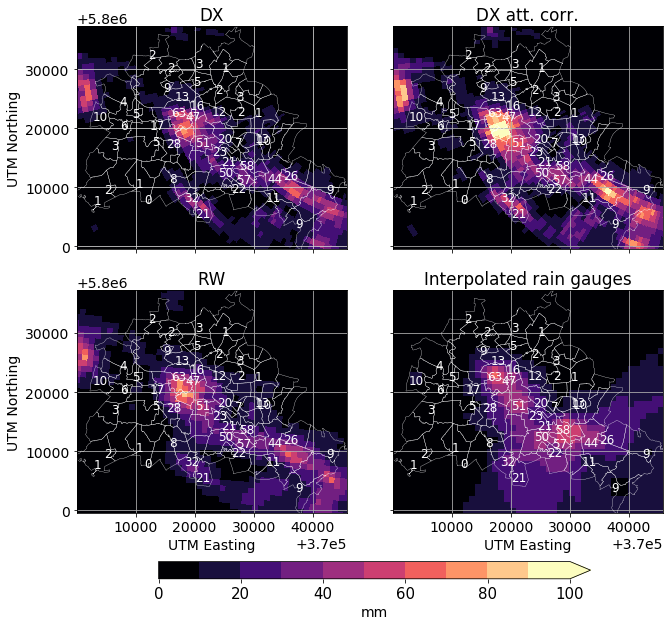

In [43]:
plt.rc('font', **{'size'   : 14})

gridcolor = "lightgray"
linecolor = "white"
#fontsize = 18

cmap = plt.cm.magma#plt.cm.nipy_spectral

bounds = np.arange(0, 110, 10)
lenmap = len(bounds) - 1
colornums = [int(i*(cmap.N-1)/(lenmap-1)) for i in (np.arange(lenmap))]
colors = [cmap(i) for i in colornums]
listedcmap = mpl.colors.ListedColormap(colors)
norm = BoundaryNorm(bounds, listedcmap.N)

fig, axs = plt.subplots(figsize=(10,8), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.ravel()

axi = 0
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
#ax, pm1 = wradlib.vis.plot_ppi(dxprec.sum(axis=0), r=r, az=az, site=site, 
#                              proj=proj, cmap=plt.cm.nipy_spectral, vmin=0, vmax=85, ax=ax)
ax, pm = wradlib.vis.plot_ppi(dxprec.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid(color=gridcolor)
#plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DX")#, fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % tmpg.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)

axi = 1
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
ax, pm = wradlib.vis.plot_ppi(dxprec2.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
#plt.xlabel("UTM Easting")
#plt.ylabel("UTM Northing")
#plt.xlim(bbox[0], bbox[1])
#plt.ylim(bbox[2], bbox[3])
plt.title("DX att. corr.")#, fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % tmpg.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)


axi = 2
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
pm = plt.pcolormesh(x_rw, y_rw, np.ma.masked_invalid(rwprec.sum(axis=0)), cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
plt.xlabel("UTM Easting")#, fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
#plt.xlim(bbox[0], bbox[1])
#plt.ylim(bbox[2], bbox[3])
plt.title("RW")#, fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % tmpg.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)


axi = 3
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
pm = plt.pcolormesh(xtrg, ytrg, ip, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
plt.xlabel("UTM Easting")#, fontsize=fontsize)
#plt.ylabel("UTM Northing")
#plt.xlim(bbox[0], bbox[1])
#plt.ylim(bbox[2], bbox[3])
plt.title("Interpolated rain gauges")#, fontsize=fontsize)
for i in gix:
    plt.text(gauges.x[i], gauges.y[i], "%d" % tmpg.sum()[i],
             horizontalalignment='center', verticalalignment='center', 
             color="white", fontsize=12)
## Good gages which are in fact bad
#bgix = np.where(np.array(gdata.sum()[gix]) < 20.)[0]
#for i in gix[bgix]:
#    plt.plot(gauges.x[i], gauges.y[i], "ro", mfc="None", ms=20, mew=2)
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)

plt.tight_layout()
#fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.25, -0.02, 0.6, 0.03])
cb = fig.colorbar(pm, cax=cbar_ax, orientation="horizontal", extend="max")
cb.set_label("mm")#, fontsize)#=fontsize)
cb.ax.tick_params(labelsize=15)

plt.savefig("docs/events/rainmap_%s.png" % eventnames[eventix], dpi=300, bbox_inches="tight")


### Diagnoseplot

In [35]:
def rmse2plot(x,y, maxval):
    plt.text(0.05*maxval, 0.9*maxval, "RMSE=%.2f mm" % h.rmse(x, y),
             fontsize=12, backgroundcolor="white")

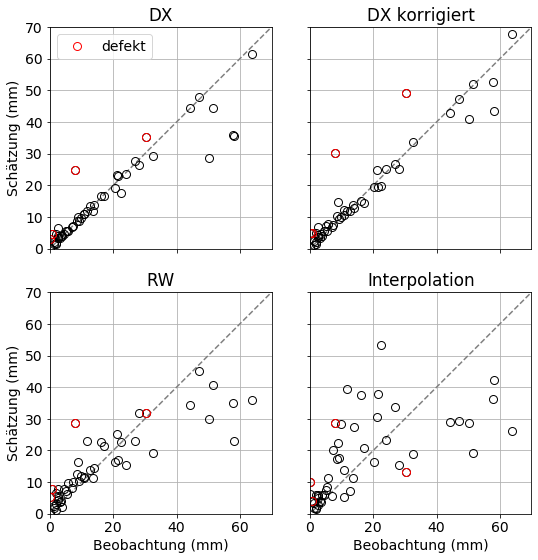

In [36]:
plt.rc('font', **{'size'   : 14})

maxval = np.nanmax(np.array((rw_at_gauge.sum(axis=0).max(), tmpg.sum(axis=0).max(), dx_at_gauge.sum(axis=0).max(), dx2_at_gauge.sum(axis=0).max(), gosum_all_est.max())))
maxval = np.ceil(maxval/10.) * 10.

fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2, sharex=True, sharey=True)
ax = ax.ravel()

#fig.suptitle(eventnames[eventix], fontsize=16)
plt.sca(ax[0])
ax[0].set_aspect("equal")
plt.plot([-10, 200], [-10, 200], color="grey", ms=0, ls="--")
plt.plot(np.array(tmpg.sum()), dx_at_gauge.sum(axis=0), "o", mfc="None", mec="black", ms=8, label="_normal")
#plt.plot(np.array(tmpg.sum())[gix], dx_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(tmpg.sum())[gauges.vegetation], dx_at_gauge.sum(axis=0)[gauges.vegetation], "go", mfc="None")
plt.plot(np.array(tmpg.sum())[bix], dx_at_gauge.sum(axis=0)[bix], "o", mfc="None", mec="red", ms=8, label="defekt")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
#plt.xlabel("Beobachtung (mm)")
plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("DX")
plt.legend()
#rmse2plot(np.array(tmpg.sum())[gix], dx_at_gauge.sum(axis=0)[gix], maxval)

plt.sca(ax[1])
ax[1].set_aspect("equal")
plt.plot([-10, 200], [-10, 200], color="grey", ms=0, ls="--")
plt.plot(np.array(tmpg.sum()), dx2_at_gauge.sum(axis=0), "o", mfc="None", mec="black", ms=8)
#plt.plot(np.array(tmpg.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(tmpg.sum())[gix][bgix], dx2_at_gauge.sum(axis=0)[gix][bgix], "ro", mfc="None")
#plt.plot(np.array(tmpg.sum())[gauges.vegetation], dx2_at_gauge.sum(axis=0)[gauges.vegetation], "go", mfc="None")
plt.plot(np.array(tmpg.sum())[bix], dx2_at_gauge.sum(axis=0)[bix], "o", mfc="None", mec="red", ms=8)
plt.xlim(0,maxval)
plt.ylim(0,maxval)
#plt.xlabel("Beobachtung (mm)")
#plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("DX korrigiert")
#rmse2plot(np.array(tmpg.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], maxval)

plt.sca(ax[2])
ax[2].set_aspect("equal")
plt.plot([-10, 200], [-10, 200], color="grey", ms=0, ls="--")
plt.plot(np.array(tmpg.sum()), rw_at_gauge.sum(axis=0), "o", mfc="None", mec="black", ms=8)
plt.plot(np.array(tmpg.sum())[bix], rw_at_gauge.sum(axis=0)[bix], "o", mfc="None", mec="red", ms=8)
#plt.plot(np.array(tmpg.sum())[gix], rw_at_gauge.sum(axis=0)[gix], "g+")
#plt.plot(np.array(tmpg.sum())[gix][bgix], rw_at_gauge.sum(axis=0)[gix][bgix], "ro", mfc="None")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Beobachtung (mm)")
plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("RW")
#rmse2plot(np.array(tmpg.sum())[gix], rw_at_gauge.sum(axis=0)[gix], maxval)

plt.sca(ax[3])
ax[3].set_aspect("equal")
plt.plot([-10, 200], [-10, 200], color="grey", ms=0, ls="--")
plt.plot(gosum_all_obs, gosum_all_est, "o", mfc="None", mec="black", ms=8)
plt.plot(np.array(tmpg.sum())[bix], gosum_all_est[bix], "o", mfc="None", mec="red", ms=8)
#plt.plot(gosum_all_obs[gix], gosum_all_est[gix], "g+")
#plt.plot(gosum_gix_obs, gosum_gix_est, "g+")
#plt.plot(gosum_gix_obs[bgix], gosum_gix_est[bgix], "ro", mfc="none")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Beobachtung (mm)")
#plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("Interpolation")
#rmse2plot(gosum_gix_obs, gosum_gix_est, maxval)

plt.tight_layout()

plt.savefig("docs/events/scatter_%s.png" % eventnames[eventix], dpi=300, bbox_inches="tight")

### Kumulativer Niederschlag über die Zeit

In [37]:
# RW
dfrw = pd.DataFrame(rw_at_gauge, index=dtimes_rw)
dfrw.columns = tmpg.columns
#dfrw = dfrw.cumsum()
# DX
dfdx = pd.DataFrame(dx_at_gauge, index=dtimes)
dfdx.columns = tmpg.columns
#dfdx = dfdx.cumsum()
# Attenutation corrected
dfdx2 = pd.DataFrame(dx2_at_gauge, index=dtimes)
dfdx2.columns = tmpg.columns
#dfdx2= dfdx2.cumsum()
# Gauge interpolation
dfgauges = pd.DataFrame(go_all_5min, index=tmpg.index)
dfgauges.columns = tmpg.columns
#dfgauges = dfgauges.cumsum()

In [38]:
tolerance = 0.99
best = []
for i, id in enumerate(tmpg.columns):
    rmse_rad = h.rmse(tmpg.cumsum().loc[starts[eventix]:ends[eventix],id], 
                      dfdx2.cumsum().loc[starts[eventix]:ends[eventix],id])
    rmse_gauge = h.rmse(tmpg.cumsum().loc[starts[eventix]:ends[eventix],id], 
                        dfgauges.cumsum().loc[starts[eventix]:ends[eventix],id])
    if rmse_rad < tolerance*rmse_gauge:
        best.append("rad")
    elif rmse_gauge < tolerance*rmse_rad:
        best.append("gauge")
    else:
        best.append("")
#best[16] = "error"
#best = np.array(best)
#print("Radar superior or equivalent in %i cases" % len(np.where(best=="rad")[0]) )

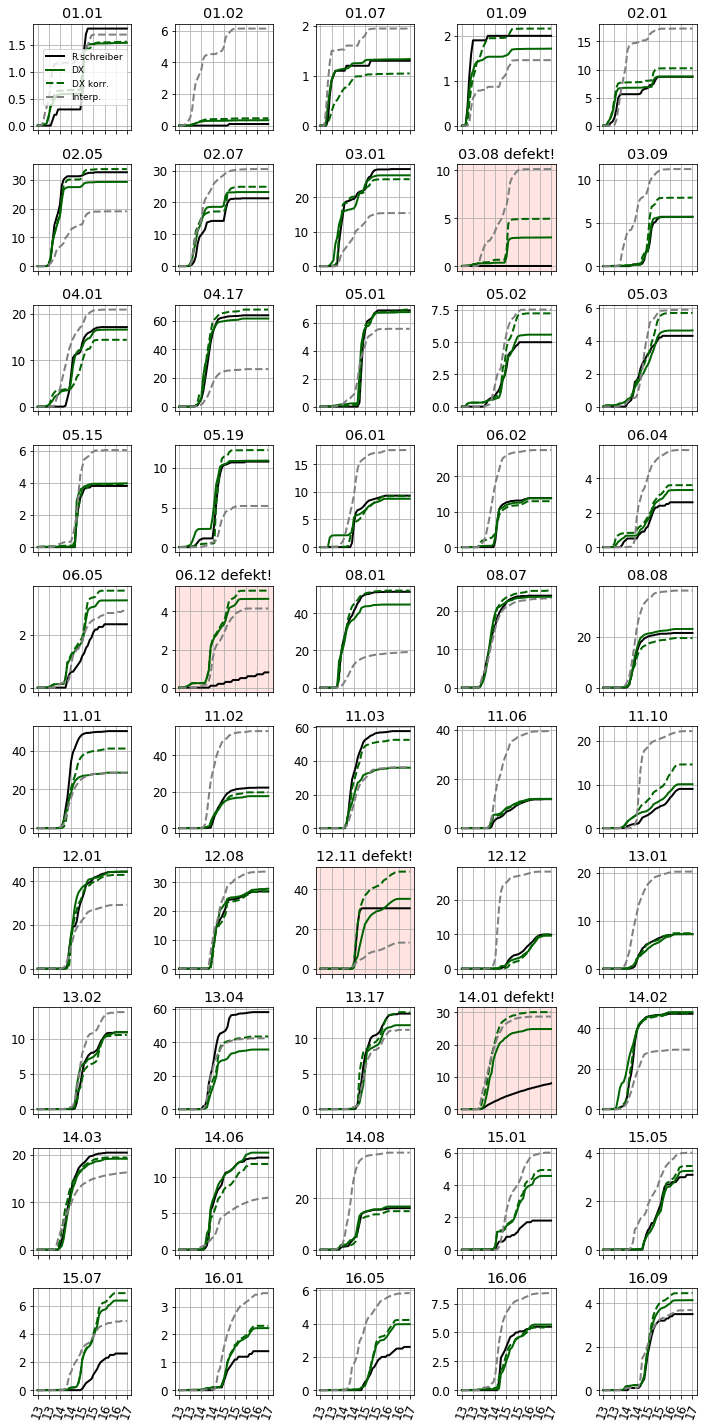

In [39]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(10,20), sharex=True)#, constrained_layout=True)
#fig.suptitle(eventnames[eventix], fontsize=16)
ax = ax.ravel()
s = starts[eventix]
e = ends[eventix]
for i, id in enumerate(tmpg.columns):
    plt.sca(ax[i])
    #tmp = dfrw.cumsum().loc[s:e,id]
    #plt.plot(tmp.index, tmp, label="RW (nur stündl.)", color="grey", lw=2)
    tmp = tmpg.cumsum().loc[s:e,id]
    plt.plot(tmp.index, tmp, label="R.schreiber", color="black", lw=2)
    tmp = dfdx.cumsum().loc[s:e,id]
    plt.plot(tmp.index, tmp, label="DX", color="darkgreen", lw=2)
    tmp = dfdx2.cumsum().loc[s:e,id]
    plt.plot(tmp.index, tmp, label="DX korr.", color="darkgreen", lw=2, ls="dashed")
    tmp = dfgauges.cumsum().loc[s:e,id]
    plt.plot(tmp.index, tmp, label="Interp.", color="grey", lw=2, ls="dashed")
    plt.grid()
    plt.xlabel("")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.xticks(rotation=70)
    if i==0:
        plt.legend(fontsize=9)
    if id in gauges.index[gauges[eventnames[eventix]]]:
        ax[i].set_facecolor('mistyrose')
        plt.title(id+" defekt!")
    else:
        plt.title(id)
    #plt.ylabel("Kumulative Regenhöhe (mm)")
    #if best[pi]=="rad":
    #    plt.text(tmpg.index[1], 50, "Radar-QPE ist überlegen", color="darkgreen", fontsize=11)
    #if best[pi]=="gauge":
    #    plt.text(tmpg.index[1], 50, "Interp. ist überlegen", color="blue", fontsize=11)
    #if best[pi]=="error":
    #    plt.text(tmpg.index[1], 50, "Regenschreiber defekt!", color="red", fontsize=11)
    #if pi==24:
    #    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #    plt.legend()
plt.tight_layout()

plt.savefig("docs/events/cumsumproducts_%s.png" % eventnames[eventix], dpi=300)

In [40]:
# plt.rc('font', **{'size'   : 12})
# fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(10,20))#, constrained_layout=True)
# #fig.suptitle(eventnames[eventix], fontsize=16)
# ax = ax.ravel()
# s = starts[eventix]
# e = ends[eventix]
# for i, id in enumerate(tmpg.columns):
#     #if i>24:
#     #    break
#     #ax = plt.subplot(5,5,pi+1)
#     ax[i].set_aspect("equal")
#     plt.sca(ax[i])
#     tmp1 = tmpg.cumsum().loc[s:e,id]
#     tmp2 = dfdx.cumsum().loc[s:e,id]
#     tmp3 = dfdx2.cumsum().loc[s:e,id]
#     plt.plot(tmp1, tmp2, label="vs. DX", color="black", lw=2)
#     plt.plot(tmp1, tmp3, label="vs. DX2", color="black", lw=2, ls="dashed")
#     plt.plot([0,100], [0,100], color="grey", ls="dashed")
#     plt.grid()
#     plt.title(id)
#     plt.xlabel("")
#     maxval = np.nanmax(np.concatenate((tmp1, tmp2, tmp3)))
#     plt.xlim(0,maxval)
#     plt.ylim(0,maxval)
#     #ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#     plt.xticks(rotation=20)
#     #plt.ylabel("Kumulative Regenhöhe (mm)")
#     #if best[pi]=="rad":
#     #    plt.text(tmpg.index[1], 50, "Radar-QPE ist überlegen", color="darkgreen", fontsize=11)
#     #if best[pi]=="gauge":
#     #    plt.text(tmpg.index[1], 50, "Interp. ist überlegen", color="blue", fontsize=11)
#     #if best[pi]=="error":
#     #    plt.text(tmpg.index[1], 50, "Regenschreiber defekt!", color="red", fontsize=11)
#     #if pi==24:
#     #    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     #    plt.legend()
# plt.tight_layout()

# plt.savefig("docs/events/cumscums_%s.png" % eventnames[eventix], dpi=300)